In [1]:
#data science
from sklearn import metrics
#data manitulation
import numpy as np
import pandas as pd
from datetime import datetime #date manipulation
#time serie ARIMA, SARIMA and SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# time series Auto-Arima
from pmdarima import auto_arima

#data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import hvplot.pandas
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import plotly.express as px
import plotly.graph_objects as go


#ojos que no ven
import warnings
warnings.filterwarnings("ignore")

In [2]:
#update color with a dark theme from visualization
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left':False,
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color':'0.9',
    'axes.labelcolor': ' 0.9',
    'xtick.color': '0.9',
    'xtick.color': '0.9',
    'font.size': 12
}
plt.rcParams.update(dark_style)

In [3]:
def eval_model(y_true, y_pred):
    print("Evaluacion de modelo:-")
    print(f"MSE: {metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred=y_pred))}")
    print(f"MAPE: {metrics.mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)}")
    print(f"R2: {metrics.r2_score(y_true=y_true, y_pred=y_pred)}")
    print(f"MAE: {metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred)}")
    

### Leer datos

Se tiene una base de datos en formato csv la cual contienen registros mensuales sobre el precio de muebles ajustado, desdde el 01-01-1992 hast 01-07-2019

In [4]:
df = pd.read_csv('/home/PedroSci/Documents/RegistroClima/TimeSeries/df_furniture.csv')
# df.head()
# df.tail()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     331 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


1. Camiar el formato de str a datetime

In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     331 non-null    datetime64[ns]
 1   furniture_price_adjusted  331 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


2. Usar la columna Monto como indice de la serie de tiempo

In [6]:
df = df.set_index("Month")
df.head()

furniture_price_adjusted
Month                               
1992-01-01               2073.432724
1992-02-01               2114.485812
1992-03-01               2260.570891
1992-04-01               2255.103236
1992-05-01               2331.414618

3. Realizamos una primer visualizacion

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1992-01-01 to 2019-07-01
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB


In [8]:
fig = px.line(df, x=df.index, y="furniture_price_adjusted", template='plotly_dark', title='Precio de Venta Forniture')
fig.show()

count      331.000000
mean      5975.765787
std       2092.867819
min       2073.432724
25%       4280.088499
50%       6075.405272
75%       7381.403461
max      10833.501852
Name: furniture_price_adjusted, dtype: float64

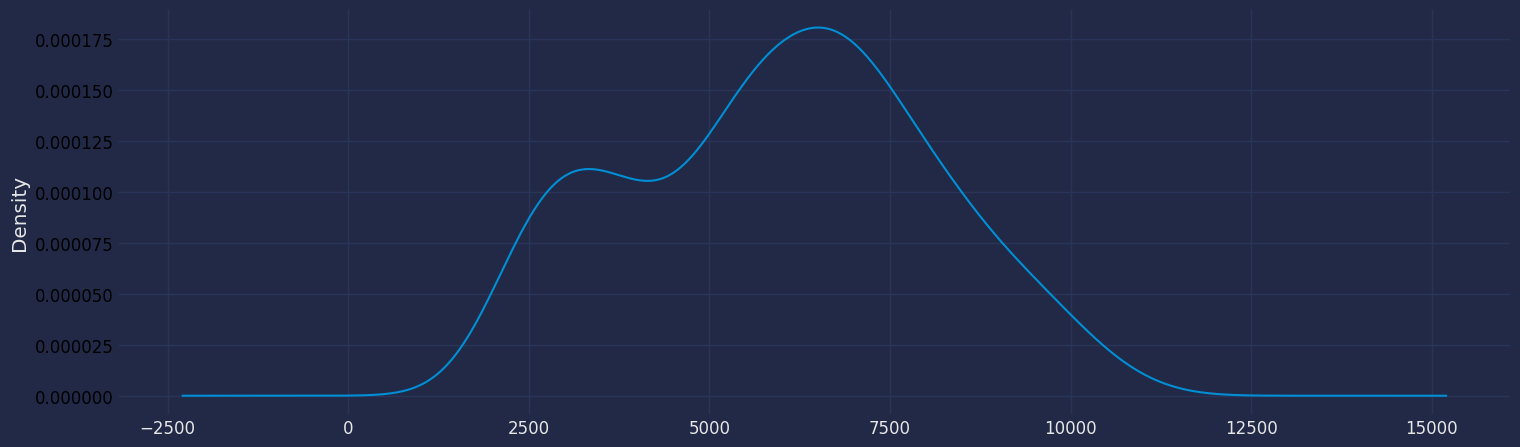

In [9]:
df['furniture_price_adjusted'].plot(kind='kde', figsize=(16,5))
df['furniture_price_adjusted'].describe()

Estacionalidad por mes

Text(0.5, 0.98, '')

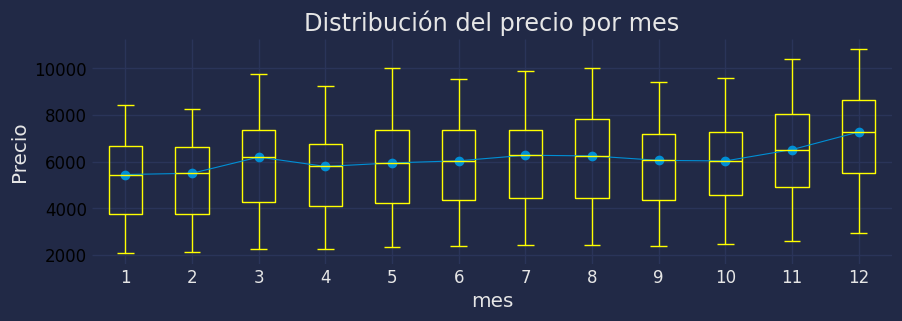

In [10]:
datos = df.copy()
fig, ax =plt.subplots(figsize=(10,3))
datos['mes'] = datos.index.month
datos.boxplot(column='furniture_price_adjusted',by='mes',ax=ax, color='yellow')
datos.groupby('mes')['furniture_price_adjusted'].median().plot(style='o-', linewidth=0.8,ax=ax)
ax.set_ylabel('Precio')
ax.set_title('Distribución del precio por mes')
fig.suptitle('')

### Supuestos Estadisticos como analisis exploratorio

La prueba de Dickey Fuller Aumentada (DFA). Para esto haremos uso de la funcion [adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) del modulo statsmodels. De los diferentes parametros que tiene, consideramos que *autolag* es:
* If “AIC” (default) or “BIC”, then the number of lags is chosen to minimize the corresponding information criterion.
* “t-stat” based choice of maxlag. Starts with maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.
* If None, then the number of included lags is set to maxlag.


La hipótesis nula del Dickey-Fuller aumentado es que existe una raíz unitaria, con la alternativa de que no la hay. 
Si el p-valor está por encima de un tamaño crítico, entonces no podemos rechazar que exista una raíz unitaria.


In [11]:
def Augmented_Dickeyy_Fuller_Test_funf(series, col_name):
    print(f"Resultaados del test de Duckey Fuller para la columna {col_name}")
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Stadistic', 'p-value', 'N° LAgs Used', 'N° observaciones utilizadas'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1]<=0.05: #p-valor del 5%
        print('Conclusion:======>')
        print('Rechazar la hipotesis nula')
        print('Los datos son estacionarios')
    else:
        print('Conclusion:======>')
        print('No se puede rechazar la hipotesis nula')
        print('Los datos no son estacionarios')


In [12]:
Augmented_Dickeyy_Fuller_Test_funf(df['furniture_price_adjusted'],'furniture_price_adjusted')

Resultaados del test de Duckey Fuller para la columna furniture_price_adjusted
Test Stadistic                  -1.128551
p-value                          0.703553
N° LAgs Used                    14.000000
N° observaciones utilizadas    316.000000
Critical Value (1%)             -3.451215
Critical Value (5%)             -2.870730
Critical Value (10%)            -2.571666
dtype: float64
Conclusion:======>
No se puede rechazar la hipotesis nula
Los datos no son estacionarios


Tambien haremos uso de una prueba con 1 diferencia. 

In [13]:
df1 = df.copy()

df1['furniture_diff']= df['furniture_price_adjusted'].diff() 
#dropna
df1.dropna(inplace=True)
df1.head()

furniture_price_adjusted  furniture_diff
Month                                               
1992-02-01               2114.485812       41.053088
1992-03-01               2260.570891      146.085079
1992-04-01               2255.103236       -5.467655
1992-05-01               2331.414618       76.311382
1992-06-01               2384.638567       53.223949

In [14]:
Augmented_Dickeyy_Fuller_Test_funf(df1['furniture_diff'],'furniture_diff')

Resultaados del test de Duckey Fuller para la columna furniture_diff
Test Stadistic                  -3.117451
p-value                          0.025288
N° LAgs Used                    17.000000
N° observaciones utilizadas    312.000000
Critical Value (1%)             -3.451484
Critical Value (5%)             -2.870849
Critical Value (10%)            -2.571730
dtype: float64
Conclusion:======>
Rechazar la hipotesis nula
Los datos son estacionarios


In [15]:
fig = px.line(df1, x=df1.index, y='furniture_diff', template='plotly_dark', title='"Precio de Venta Furniture')
fig.show()

GRaficos de autocorrelacion

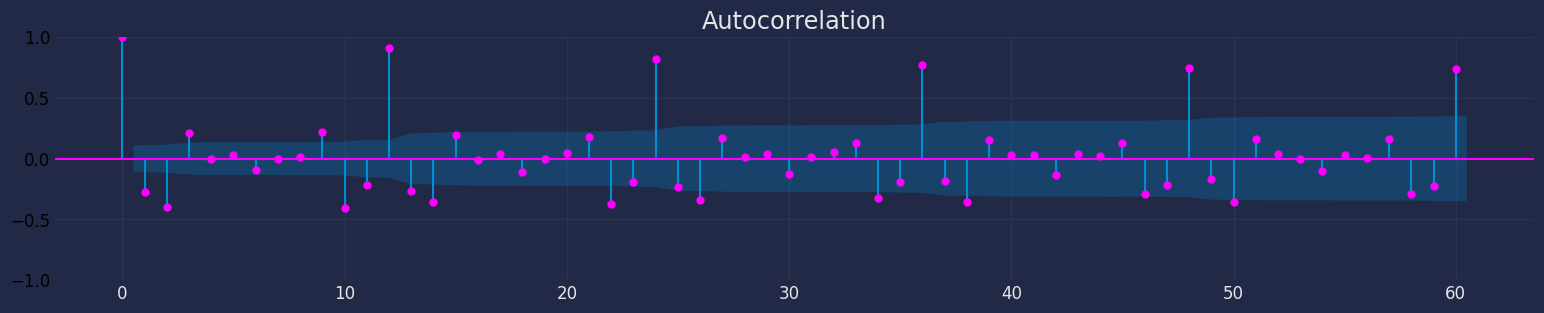

In [16]:
fig, ax = plt.subplots(figsize=(17,3))
plot_acf(df1['furniture_diff'], ax=ax, lags=60, color='fuchsia')
plt.show()

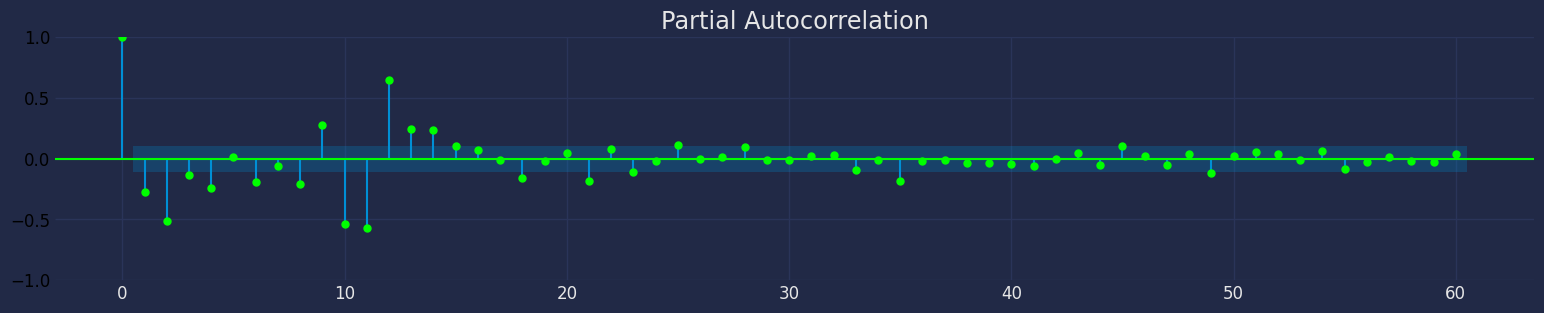

In [17]:
#autocorrelacion parcial

fig, ax = plt.subplots(figsize=(17,3))
plot_pacf(df1['furniture_diff'], ax=ax, lags=60, color='lime')
plt.show()

SARIMA

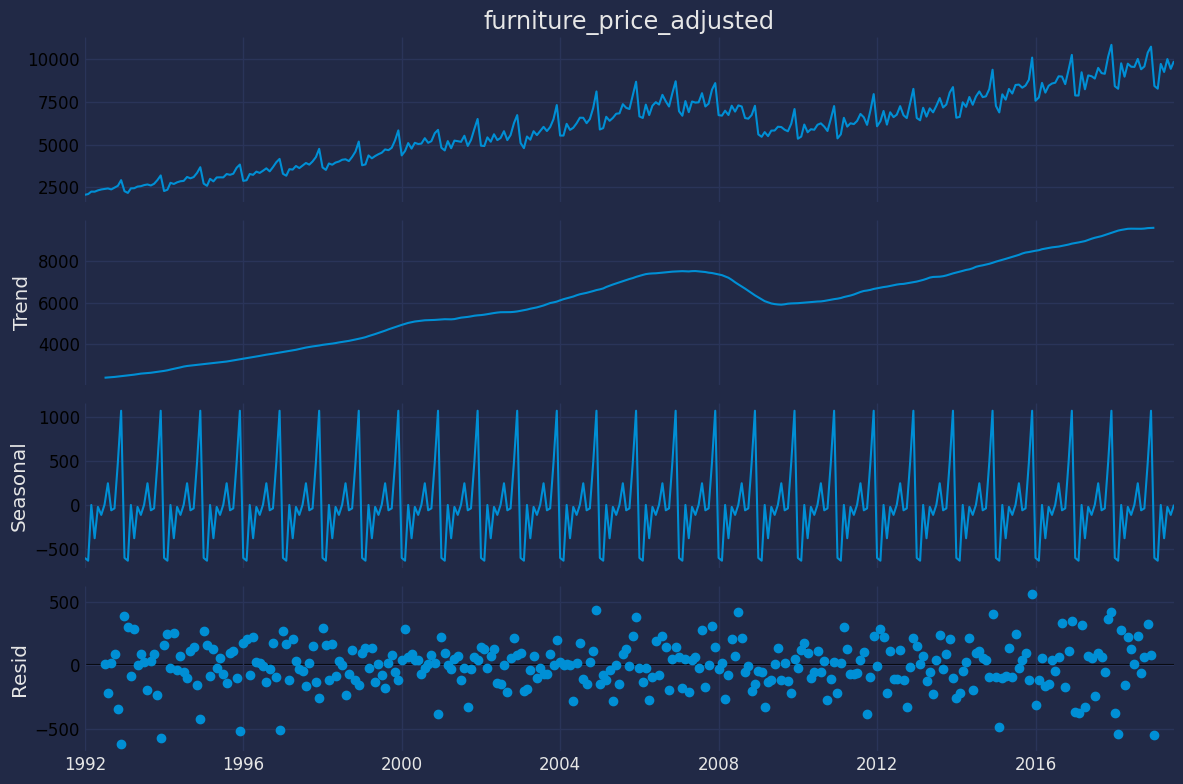

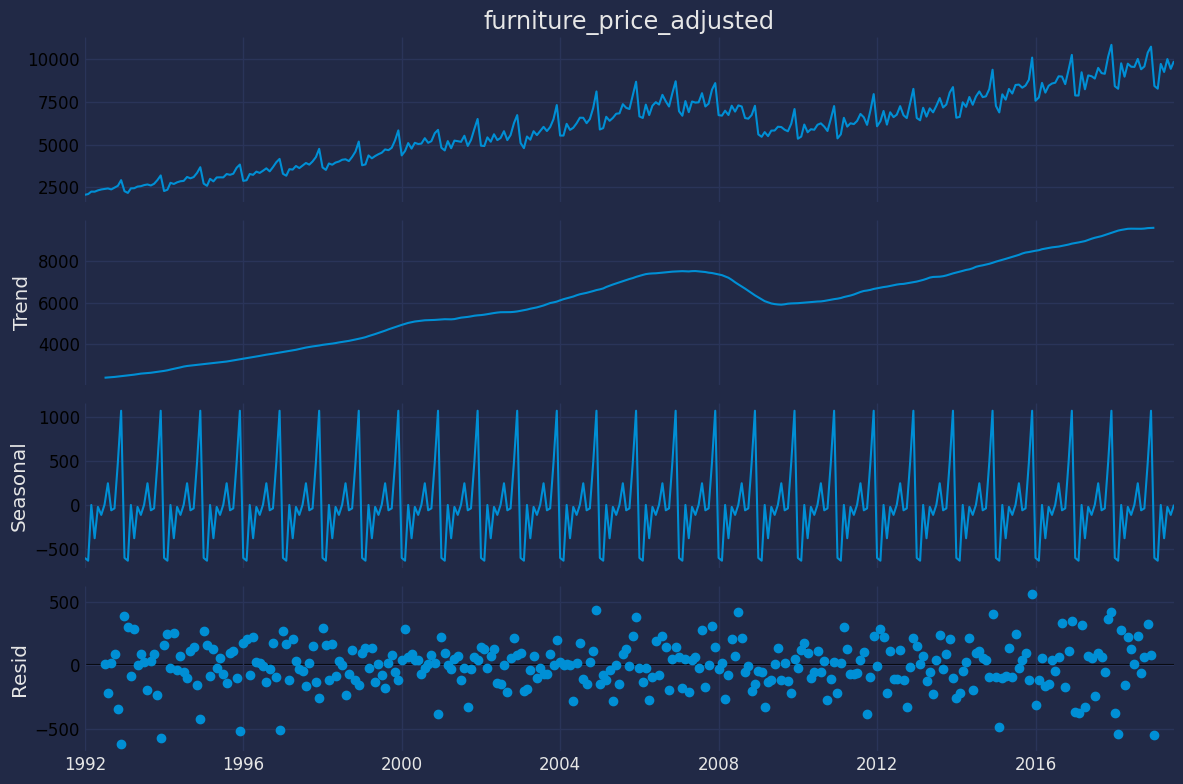

In [18]:
plt.rcParams['figure.figsize']=(12,8)
a = seasonal_decompose(df['furniture_price_adjusted'], model='add')
a.plot()

### Train test split

In [19]:
train_data= df[:len(df)-16]
test_data = df[len(df)-16:]
test = test_data.copy()
train_data.shape, test_data.shape

((315, 1), (16, 1))

## Forecast en series de tiempo

### ARIMA (Autoregresive Integrate Movin Average)


* AR (Autoregresion)
* I (Integrado) 
* MA (Promedio movil)

Se tiende a usar la siguiente notacion:
* p: El numero de observaciones de retraso del modelo, usualmente coocido como *'lag*
* d: el numero de veces que se diferencian las observaciones, conocido como grado de diferenciacion
* q: el tamaño de ventana, conocido como *'media movil'*


La definicion formal de un modekos es el siguiente:

$$X_i = c + \epsilon_t + \sum_{i=1}^p \phi_i X_{t-i} + \sum_{i=1}^q\theta_i \epsilon_{t-i} + \delta_t$$






| Modelo       | $p \\ d \\ q$  | Diferenciado |Método |
|--------------|----------------|--------------|-------|
|Arima(0,0,0)  | $0 \\ 0 \\ 0$ |$y_t = \epsilon_t$     |              | Ruido blanco |
|ARIMA(0.1,0)  |  $0 \\ 1 \\ 0$ |$y_t = Y_t- Y_{t-1}$          | Caminata aleatoria|
|ARIMA(0,2,0)  |  $0 \\ 2 \\ 0$ |$y_t = Y_t- Y_{t-1}$          | Caminata aleatoria|

In [20]:
modelo_auto= auto_arima(train_data, start_p=0,start_q=0, max_p=4, max_d=2, max_q=4, start_P=0,
                    D=1,start_Q=0, max_P=2, max_D=1,
                    max_Q=2,m=12,seasonal=True,
                    error_action ='warn', trace=True,
                    suppress_warnings=True,stepwise=True,
                    random_state=20,n_fits=50
                    )
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4488.338, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4117.050, Time=0.20 sec


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4293.628, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4601.823, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4117.151, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4105.492, Time=0.78 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=4085.375, Time=1.61 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=4095.600, Time=0.51 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=4090.564, Time=2.26 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=4049.182, Time=1.72 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=4053.528, Time=0.85 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4063.657, Time=1.36 sec
 ARIMA(2,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=4074.520, Time=0.44 sec
 ARIMA(2,0,0)(1,1,2)[12] intercept   : AIC=4051.421, Time=2.56 sec
 ARIMA(3,0

(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)

In [21]:
print(modelo_auto.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  315
Model:             SARIMAX(3, 0, 0)x(2, 1, [1, 2], 12)   Log Likelihood               -2003.133
Date:                                 Wed, 28 Feb 2024   AIC                           4024.265
Time:                                         09:25:56   BIC                           4057.689
Sample:                                     01-01-1992   HQIC                          4037.637
                                          - 03-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8496      7.394      1.332      0.183      -4.643      24

In [22]:
modelo_auto.predict(start = len(train_data), end= len(df)-1, typ='levels')

2018-04-01     8842.718284
2018-05-01     9649.918046
2018-06-01     9494.165989
2018-07-01     9524.433122
2018-08-01    10086.803079
2018-09-01     9696.329316
2018-10-01     9772.919943
2018-11-01    10587.441181
2018-12-01    11337.130362
2019-01-01     8953.665024
Freq: MS, dtype: float64

## implementacion del modelo

In [23]:
arima_model = SARIMAX(train_data['furniture_price_adjusted'], order=(3, 0, 0), seasonal_order=(2,1,2,12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64785D+00    |proj g|=  5.75749D-01


 This problem is unconstrained.



At iterate    5    f=  6.38359D+00    |proj g|=  2.71747D-02

At iterate   10    f=  6.38191D+00    |proj g|=  1.73814D-02

At iterate   15    f=  6.37565D+00    |proj g|=  2.63289D-02

At iterate   20    f=  6.37333D+00    |proj g|=  1.97065D-02

At iterate   25    f=  6.37156D+00    |proj g|=  4.92119D-03

At iterate   30    f=  6.37134D+00    |proj g|=  8.96259D-04

At iterate   35    f=  6.37095D+00    |proj g|=  2.70345D-02

At iterate   40    f=  6.36574D+00    |proj g|=  3.36238D-02

At iterate   45    f=  6.36401D+00    |proj g|=  2.78100D-02

At iterate   50    f=  6.36234D+00    |proj g|=  1.71302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

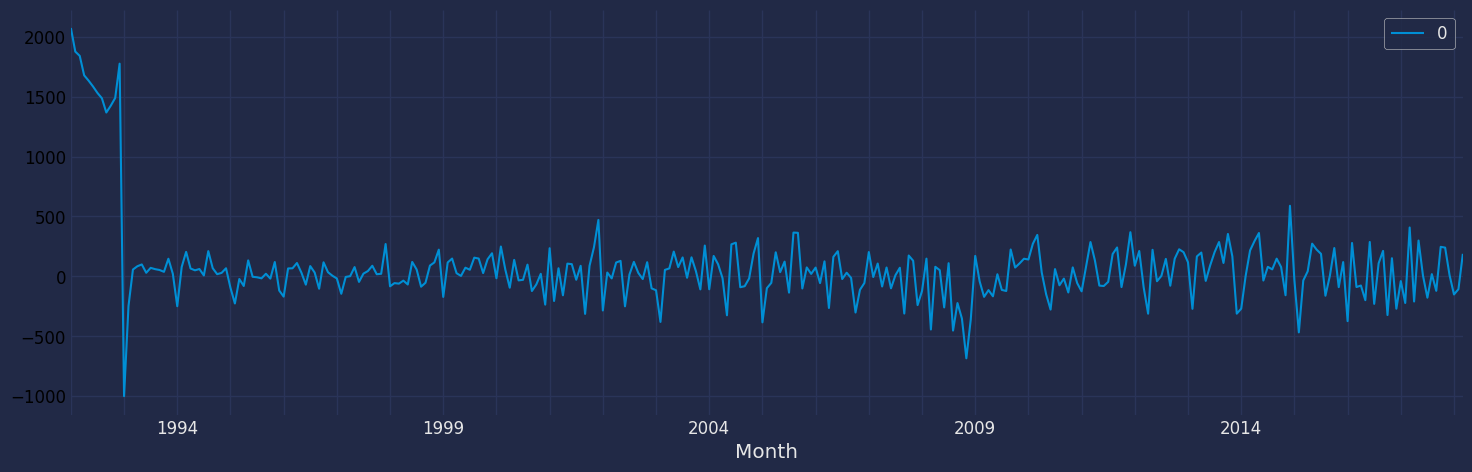

In [24]:
residuals =pd.DataFrame(arima_model.resid)
residuals.plot(figsize=(16,5))
plt.show()

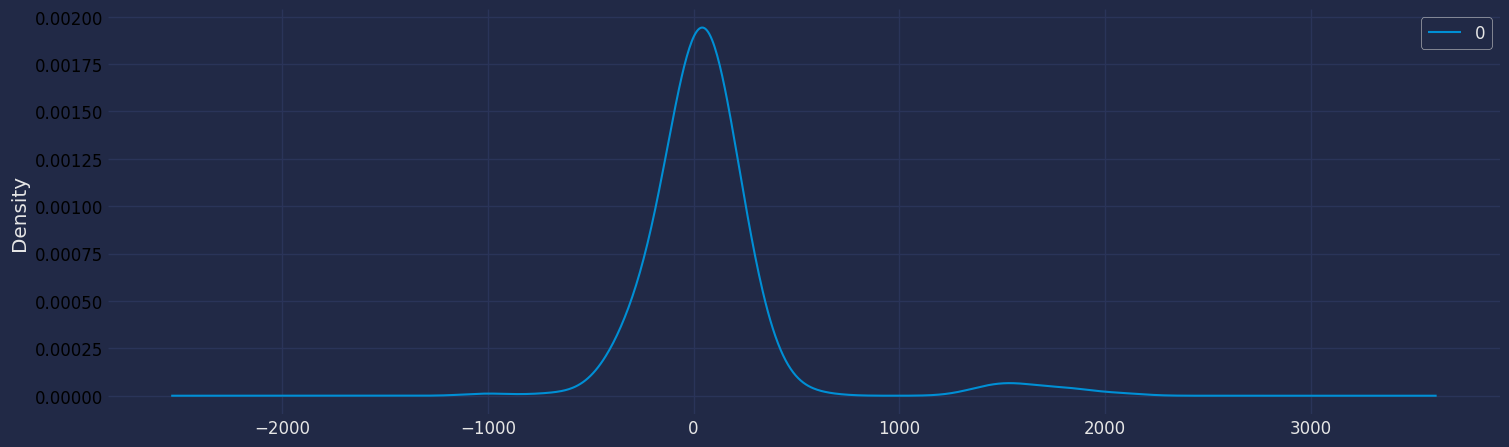

                 0
count   315.000000
mean     78.590385
std     363.274210
min   -1001.362296
25%     -81.241865
50%      37.054204
75%     146.379195
max    2073.432724


In [25]:
#diagrama de densidad del kernel de errores residuales
residuals.plot(kind='kde', figsize=(16,5))
plt.show()
print(residuals.describe())

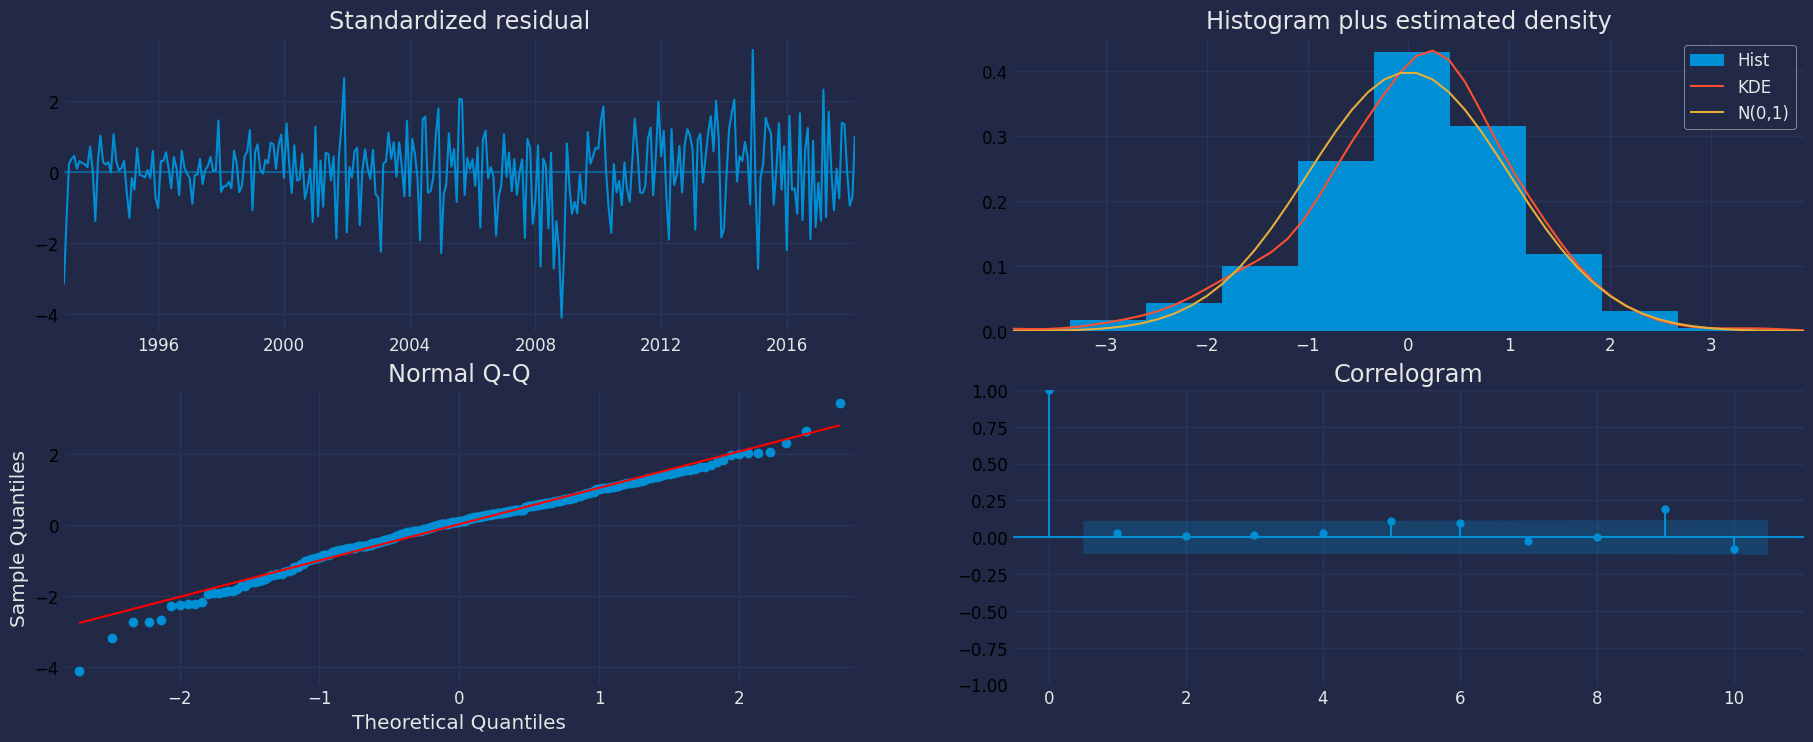

In [26]:
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

In [27]:
arima_pred = arima_model.predict(start=len(train_data), end=len(df)-1, type='levels') #equivalentemente, start = '2015-01-01, end = 2025-01-01
arima_pred

2018-04-01     8832.312136
2018-05-01     9640.190653
2018-06-01     9483.690131
2018-07-01     9504.849764
2018-08-01    10063.546097
2018-09-01     9665.270393
2018-10-01     9738.182496
2018-11-01    10543.151111
2018-12-01    11284.501521
2019-01-01     8894.658886
2019-02-01     8658.508089
2019-03-01     9967.870486
2019-04-01     9243.604849
2019-05-01    10020.990673
2019-06-01     9821.710574
2019-07-01     9951.536920
Freq: MS, Name: predicted_mean, dtype: float64

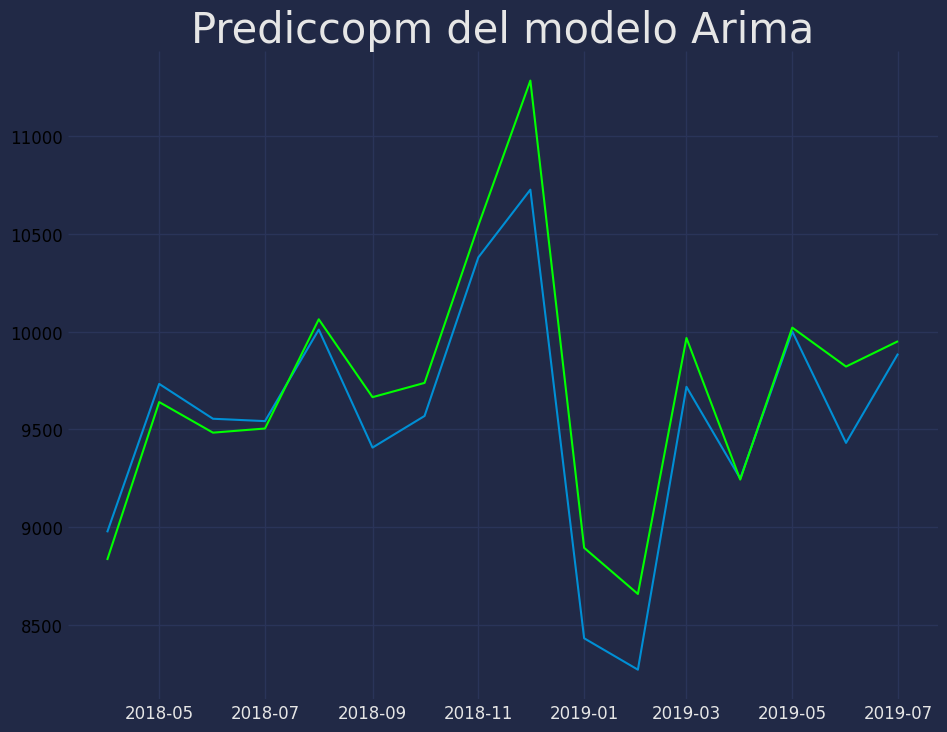

In [28]:
plt.rcParams['figure.figsize'] = (10,8)

plt.plot(test_data['furniture_price_adjusted'], label='real')
plt.plot(arima_pred, color='lime',label='Prediccion')
plt.title('Prediccopm del modelo Arima', fontsize=30)
plt.show()